In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 35
CHANNELS = 3

In [3]:
train_directory = "C:/projekty/Apple_diease/train"

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    shuffle =True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 9748 files belonging to 5 classes.


In [4]:
test_directory = "C:/projekty/Apple_diease/test"

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    shuffle =True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 2959 files belonging to 5 classes.


In [5]:
train_names = train_set.class_names
train_names

['alternaria', 'apple_scab', 'black_rot', 'cedar_apple_rust', 'healthy']

In [6]:
n_classes = len(train_names)
n_classes

5

In [7]:
for image_batch, label_batch in train_set.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(16, 128, 128, 3)
[4 4 2 0 0 4 3 2 0 1 4 2 0 1 2 0]


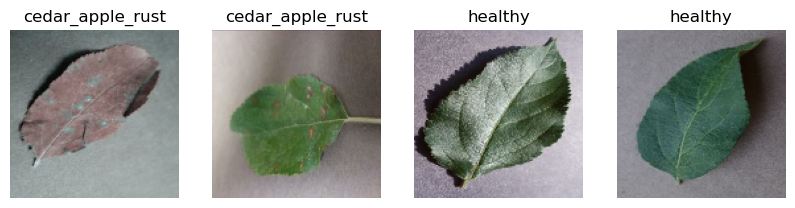

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_set.take(1):
  for i in range (4):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(train_names[label_batch[i]])
    plt.axis("off")

In [9]:
len(train_set)

610

In [10]:
len(test_set)

185

In [11]:
# # separation validation set from test set
# val_set=test_set.take(30)
# len(val_set)

In [12]:
# test_set = test_set.skip(30)

In [13]:
# test_set splited to test_set and val_set

def get_test_set_val_set (ts, val_split=0.5, test_split=0.5, shuffle=True, shuffle_size=10000):

  ts_size = len(ts)

  if shuffle:
    ts = ts.shuffle(shuffle_size, seed = 12)
  test_size = int(test_split*ts_size)
  val_size = int(val_split*ts_size)

  test_set = ts.take(test_size)
  val_set = ts.skip(test_size).take(val_size)

  return test_set, val_set

In [14]:
test_set, val_set = get_test_set_val_set(test_set)

In [15]:
len(test_set)

92

In [16]:
len(val_set)

92

In [17]:
len(train_set)

610

In [18]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),

])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = n_classes
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 8)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation="relu", input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (16, 63, 63, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 30, 30, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer = "adam",
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [24]:
history = model.fit(
    train_set,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_set,
    callbacks=[es]
)

Epoch 1/35
610/610 [==============================] - 57s 89ms/step - loss: 0.8114 - accuracy: 0.6589 - val_loss: 0.4472 - val_accuracy: 0.8376
Epoch 2/35
610/610 [==============================] - 53s 86ms/step - loss: 0.3232 - accuracy: 0.8868 - val_loss: 0.1513 - val_accuracy: 0.9484
Epoch 3/35
610/610 [==============================] - 54s 89ms/step - loss: 0.2212 - accuracy: 0.9225 - val_loss: 0.2558 - val_accuracy: 0.9178
Epoch 4/35
610/610 [==============================] - 53s 87ms/step - loss: 0.1591 - accuracy: 0.9434 - val_loss: 0.1760 - val_accuracy: 0.9375
Epoch 5/35
610/610 [==============================] - 54s 88ms/step - loss: 0.1237 - accuracy: 0.9563 - val_loss: 0.1174 - val_accuracy: 0.9654
Epoch 6/35
610/610 [==============================] - 53s 87ms/step - loss: 0.1277 - accuracy: 0.9570 - val_loss: 0.0886 - val_accuracy: 0.9701
Epoch 7/35
610/610 [==============================] - 53s 88ms/step - loss: 0.1054 - accuracy: 0.9637 - val_loss: 0.0355 - val_accuracy:

In [25]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 610}

In [26]:
es_n = len(history.history['loss'])
es_n

28

In [27]:
scores = model.evaluate(test_set)

92/92 [==============================] - 2s 20ms/step - loss: 0.0248 - accuracy: 0.9925


In [28]:
# number of processed epoch
es_list = list(range(1,es_n+1))

In [29]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

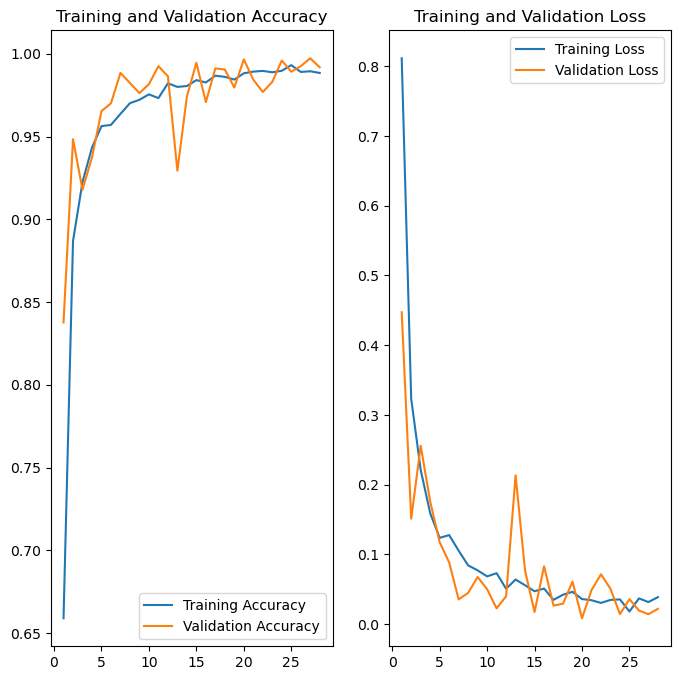

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot((es_list), acc, label="Training Accuracy")
plt.plot((es_list), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot((es_list), loss, label="Training Loss")
plt.plot((es_list), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [31]:
# plt.figure(figsize=(10,10))
# for image_batch, label_batch in train_set.take(1):
#   for i in range (4):
#     ax = plt.subplot(3,4,i+1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(train_names[label_batch[i]])
#     plt.axis("off")

first image to predict
actual label:  apple_scab
1/1 [==============================] - 0s 87ms/step
predicted label:  apple_scab


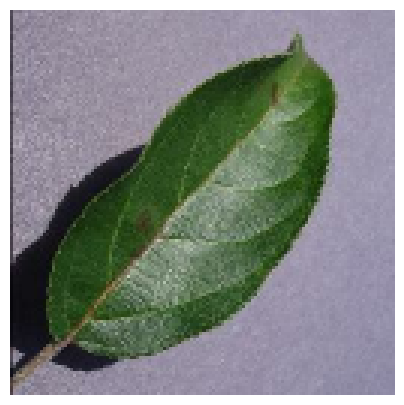

In [32]:
# checking and showing prediction
plt.figure(figsize=(5,5))
for images_bach, labels_bach in test_set.take(1):

  first_image = (images_bach[i].numpy().astype("uint8"))
  first_label = labels_bach[i].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  plt.axis("off")
  print("actual label: ", train_names[first_label])

  batch_prediction = model.predict(images_bach)
  print("predicted label: ", train_names[np.argmax(batch_prediction[i])])


In [33]:

model.save("Appple_diesases_model.h5")

C:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('my_model.keras')`.
  saving_api.save_model(